In [1]:
%pip install pandas matplotlib scipy seaborn xelatex

ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from scipy.signal import savgol_filter
from dateutil import tz
import itertools
from matplotlib import pyplot, dates
import matplotlib.ticker as ticker
import pytz

In [7]:
from common import combine_csvs
from common import region_mapping
import common

from common import N_STARLINK
from common import N_STARLINK_REMOTE
from common import N_HOME
from common import N_HAMPTON
from common import N_MOTION

In [8]:
N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
N_LATENCY = 'Latency (ms)'

WIDTH_THIRD = 2.2
WIDTH_HALF = 3.4
WIDTH_FULL = 7.15

REGION_ORDER = ['N. California', 'Tokyo', 'London', 'Sydney', 'Singapore',
            'Sao Paulo', 'Bahrain', 'Mumbai', 'Cape Town']

#src_dirs = ['data/trad_ping_2022-04-14', 'data/starlink_ping_2022-04-14/']
#src_dirs = ['data/Home_network_data/Ping/2022-06-06_traditional_measures_ping/', 'data/starlink-data/Ping/2022-06-06_starlink_ping/']
#src_dirs = [
#    ('Home', 'data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/'), 
#    ('Starlink', 'data/starlink-data/Ping/2022-06-03_starlink_measurements_ping/'),
#    ('Home', 'data/Home_network_data/Ping/2022-06-06_traditional_measures_ping/'),
#    ('Starlink', 'data/starlink-data/Ping/2022-06-06_starlink_ping/'),
#]

N_OUTLIERS = 'Outliers'
N_DISHA = 'Dish A'

OUT_PATH = 'output/Ping'
filename = os.path.join(OUT_PATH, 'out_plot')

In [23]:
src_dirs = []
for folder in glob.glob('data/starlink-data/Ping/*'):
    if os.path.isdir(folder):
        src_dirs.append(('Starlink', folder))
for folder in glob.glob('data/Home_network_data/Ping/*'):
    if os.path.isdir(folder):
        src_dirs.append(('Home', folder))
        
#src_dirs = [(N_STARLINK, 'data/starlink-data/Ping/sydney_2022-07-21_starlink_ping/')]
#src_dirs += [(N_HOME, 'data/Home_network_data/Ping/sydney_2022-07-21_trad_ping/')]

#src_dirs = [(N_STARLINK, 'data/starlink-data/Ping/motion_starlink_ping/')]

#src_dirs = [(N_HAMPTON, 'data/starlink-data/Ping/2022-07-13_starlink_mann_ping/')]

#src_dirs = [(N_STARLINK, 'data/starlink-data/Ping/2022-06-28_xiaoqiang_starlink_ping/')]

#src_dirs = [(N_STARLINK, 'data/starlink-data/Ping/2022-04-12_starlink_ping/')]
#src_dirs = [(N_STARLINK_REMOTE, 'data/Koeye/koeye_ping_measurements_2022-05-20/')]

#src_dirs = [('Dish C', 'data/starlink-data/Ping/2022-06-28_xiaoqiang_starlink_ping/')]
src_dirs

[('Starlink', 'data/starlink-data/Ping/2022-04-12_starlink_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-07-03_starlink_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-05-28_starlink_measurements_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-07-13_starlink_mann_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-06-28_xiaoqiang_starlink_ping'),
 ('Starlink', 'data/starlink-data/Ping/motion_starlink_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-06-03_starlink_measurements_ping'),
 ('Starlink', 'data/starlink-data/Ping/sydney_2022-07-21_starlink_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-05-09_starlink_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-06-06_starlink_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-05-19_starlink_ping'),
 ('Home', 'data/Home_network_data/Ping/2022-07-20_trad_ping'),
 ('Home', 'data/Home_network_data/Ping/2022-06-03_traditional_measures_ping'),
 ('Home', 'data/Home_network_data/Ping/2022-06-21_traditional_measures_ping')

In [24]:
pd.DataFrame(src_dirs).to_csv('out.csv')

In [25]:
plot_params = common.plot_params.copy()
plot_params['figure.figsize'] = (7.16, 4)
plot_params['figure.dpi'] = 96
#matplotlib.rcParams.update(plot_params)

sns_params = common.sns_params.copy()
sns_params['figure.figsize'] = (7.16, 4)
sns_params['figure.dpi'] = 96
sns_params['patch.edgecolor'] = 'black'
sns.set_theme("paper", style='whitegrid', rc=sns_params, color_codes=True, palette='bright')
#sns.set_context("paper", rc=sns_params)
#sns.set(rc=sns_params)

In [5]:
df_old = pd.read_csv(os.path.join(OUT_PATH, '2022-06-17_end_all_ping_data.csv'), index_col=False)
df_old[N_TIMESTAMP] = pd.to_datetime(df_old[N_TIMESTAMP])
df_old

,Latency (ms),Timestamp,Regions,Type,Outliers
0,57.4,2022-04-13 05:06:07,N. California,Starlink,False
1,47.8,2022-04-13 05:06:08,N. California,Starlink,False
2,61.9,2022-04-13 05:06:09,N. California,Starlink,False
3,52.9,2022-04-13 05:06:10,N. California,Starlink,False
4,51.0,2022-04-13 05:06:11,N. California,Starlink,False
...,...,...,...,...,...
54583138,289.0,2022-06-17 08:39:47,Cape Town,Terrestrial,False
54583139,145.0,2022-06-17 08:39:47,London,Terrestrial,False
54583140,261.0,2022-06-17 08:39:47,Mumbai,Terrestrial,False
54583141,156.0,2022-06-17 08:39:47,Sydney,Terrestrial,False


In [9]:
df_old.sort_values(N_TIMESTAMP)

,Latency (ms),Timestamp,Regions,Type,Outliers
0,57.4,2022-04-13 05:06:07,N. California,Starlink,False
1,47.8,2022-04-13 05:06:08,N. California,Starlink,False
2,61.9,2022-04-13 05:06:09,N. California,Starlink,False
3,52.9,2022-04-13 05:06:10,N. California,Starlink,False
4,51.0,2022-04-13 05:06:11,N. California,Starlink,False
...,...,...,...,...,...
54583128,190.0,2022-06-17 08:39:47,Sao Paulo,Terrestrial,False
54583127,289.0,2022-06-17 08:39:47,Cape Town,Terrestrial,False
54583141,156.0,2022-06-17 08:39:47,Sydney,Terrestrial,False
54583133,143.0,2022-06-17 08:39:47,Tokyo,Terrestrial,False


In [10]:
#df_old.pivot_table(columns=[N_TYPE, N_REGIONS], values=N_LATENCY, aggfunc='std')
a = df_old[df_old[N_TYPE] == N_STARLINK].pivot_table(columns=[N_REGIONS], values=N_LATENCY, aggfunc='count')
b = df_old[df_old[N_TYPE] == N_HOME].pivot_table(columns=[N_REGIONS], values=N_LATENCY, aggfunc='count')

print(a)
print(b)
#std_ratio = (a / b)
#std_ratio
#a - b

Regions       Bahrain  Cape Town   London   Mumbai  N. California  Sao Paulo  \
Latency (ms)  2482150    2021287  3219399  3220087        3633959    3220023   

Regions       Singapore   Sydney    Tokyo  
Latency (ms)    3220049  3647910  3219418  
Regions       Bahrain  Cape Town   London   Mumbai  N. California  Sao Paulo  \
Latency (ms)  2924089    2503075  2923992  2922577        3327672    2925061   

Regions       Singapore   Sydney    Tokyo  
Latency (ms)    2922679  3327507  2922209  


In [12]:
#df_old.pivot_table(columns=[N_TYPE, N_REGIONS], values=N_LATENCY, aggfunc='std')
df_old.pivot_table(index=N_TYPE, columns=[N_REGIONS], values=N_LATENCY)

#print(a)
#print(b)
#std_ratio = (a / b)
#std_ratio

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Type,,,,,,,,,
Starlink,266.696232,310.377467,168.085194,284.594823,55.383745,213.843563,198.684958,230.887662,151.918970
Terrestrial,258.341745,296.039889,152.046133,271.701787,34.491404,191.006578,196.848192,152.464079,142.680309


In [53]:
#df_old.pivot_table(columns=[N_TYPE, N_REGIONS], values=N_LATENCY, aggfunc='std')
a = df_old[df_old[N_TYPE] == N_STARLINK].pivot_table(columns=[N_REGIONS], values=N_LATENCY, aggfunc='std')
b = df_old[df_old[N_TYPE] == N_HOME].pivot_table(columns=[N_REGIONS], values=N_LATENCY, aggfunc='std')

std_ratio = (a / b)
std_ratio

In [8]:
df_old[df_old[N_TYPE] == N_STARLINK][N_LATENCY].mean() / df_old[df_old[N_TYPE] == N_HOME][N_LATENCY].mean()

1.093988906338633

In [56]:
std_ratio.mean().mean()

3.7709403924740363

In [10]:
df_sample = df_old.groupby([N_TYPE, N_REGIONS]).sample(300000, random_state=0)
df_sample

,Latency (ms),Timestamp,Regions,Type,Outliers
8252369,245.0,2022-05-14 05:09:43,Bahrain,Starlink,False
4308775,255.0,2022-05-11 08:18:13,Bahrain,Starlink,False
27040014,260.0,2022-06-07 13:46:44,Bahrain,Starlink,False
24283949,236.0,2022-06-06 16:19:31,Bahrain,Starlink,False
15372134,236.0,2022-06-01 18:49:32,Bahrain,Starlink,False
...,...,...,...,...,...
53317364,142.0,2022-06-16 21:34:17,Tokyo,Terrestrial,False
41874455,144.0,2022-06-12 19:40:46,Tokyo,Terrestrial,False
12989137,140.0,2022-05-31 05:53:50,Tokyo,Terrestrial,False
54378383,141.0,2022-06-17 06:51:16,Tokyo,Terrestrial,False


In [29]:
df_interv = df_old
df_interv = df_interv[(df_interv[N_TIMESTAMP] > '2022-06-16 23:00') & (df_interv[N_TIMESTAMP] <= '2022-06-17')].sort_values(N_TIMESTAMP)
df_interv = df_interv[(df_interv[N_REGIONS] == 'N. California') & (df_interv[N_TYPE] == N_STARLINK)]
df_interv

,Latency (ms),Timestamp,Regions,Type,Outliers
53479172,46.3,2022-06-16 23:00:01,N. California,Starlink,False
53479173,46.3,2022-06-16 23:00:01,N. California,Starlink,False
53479218,44.3,2022-06-16 23:00:02,N. California,Starlink,False
53479221,44.3,2022-06-16 23:00:02,N. California,Starlink,False
53479249,42.6,2022-06-16 23:00:03,N. California,Starlink,False
...,...,...,...,...,...
53592806,60.9,2022-06-16 23:59:58,N. California,Starlink,False
53592858,43.7,2022-06-16 23:59:59,N. California,Starlink,False
53592835,43.7,2022-06-16 23:59:59,N. California,Starlink,False
53592881,41.7,2022-06-17 00:00:00,N. California,Starlink,False


In [43]:
# Every drastic change, record the timestamp
thresh = 10
ts = []
prev_freq = None
for _, row in df_interv.iterrows():
    lat = row[N_LATENCY]
    if prev_freq:
        if np.abs(prev_freq - lat) > thresh:
            ts.append(row[N_TIMESTAMP])
        
    prev_freq = lat
    
ts

[Timestamp('2022-06-16 23:00:12'),
 Timestamp('2022-06-16 23:00:13'),
 Timestamp('2022-06-16 23:00:16'),
 Timestamp('2022-06-16 23:00:17'),
 Timestamp('2022-06-16 23:00:20'),
 Timestamp('2022-06-16 23:00:21'),
 Timestamp('2022-06-16 23:00:22'),
 Timestamp('2022-06-16 23:00:26'),
 Timestamp('2022-06-16 23:00:42'),
 Timestamp('2022-06-16 23:00:44'),
 Timestamp('2022-06-16 23:00:49'),
 Timestamp('2022-06-16 23:01:34'),
 Timestamp('2022-06-16 23:01:36'),
 Timestamp('2022-06-16 23:01:38'),
 Timestamp('2022-06-16 23:01:46'),
 Timestamp('2022-06-16 23:02:12'),
 Timestamp('2022-06-16 23:02:13'),
 Timestamp('2022-06-16 23:02:16'),
 Timestamp('2022-06-16 23:02:28'),
 Timestamp('2022-06-16 23:02:29'),
 Timestamp('2022-06-16 23:02:33'),
 Timestamp('2022-06-16 23:02:36'),
 Timestamp('2022-06-16 23:02:37'),
 Timestamp('2022-06-16 23:02:39'),
 Timestamp('2022-06-16 23:02:40'),
 Timestamp('2022-06-16 23:02:41'),
 Timestamp('2022-06-16 23:02:42'),
 Timestamp('2022-06-16 23:02:43'),
 Timestamp('2022-06-

In [18]:
df_old = df_old.replace('Home', N_HOME)
df_old.to_csv(os.path.join(OUT_PATH, '2022-06-17_end_all_ping_data.csv'), index=False)

In [41]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    for region in glob.glob(f'{folder}/*'):
        pattern = f"{region}/*"
        print(pattern)
        #print(pattern)
        df_temp = combine_csvs(glob.glob(pattern, recursive=True), None, header=None)
        df_temp = df_temp.iloc[:,[2, 3]]
        df_temp.rename(columns={df_temp.columns[0]: N_LATENCY, df_temp.columns[1]: N_TIMESTAMP}, inplace=True)
        df_temp[N_TIMESTAMP] = pd.to_datetime(df_temp[N_TIMESTAMP], unit='s')
        df_temp.sort_values(N_TIMESTAMP, inplace=True)
        df_temp[N_REGIONS] = region_mapping[os.path.basename(region)]
        df_temp[N_TYPE] = type_name

        if not df.empty:
            #df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
            #df = df.update(df_temp, errors='raise')
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
            

df[N_TIMESTAMP] = df[N_TIMESTAMP].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df = df.reset_index(drop=True)
df

data/starlink-data/Ping/2022-04-12_starlink_ping/Asia_Pacific_Sydney/*
data/starlink-data/Ping/2022-04-12_starlink_ping/US_West_N_California/*


,Latency (ms),Timestamp,Regions,Type
402944,57.4,2022-04-12 22:06:07-07:00,N. California,Starlink
402945,47.8,2022-04-12 22:06:08-07:00,N. California,Starlink
402946,61.9,2022-04-12 22:06:09-07:00,N. California,Starlink
402947,52.9,2022-04-12 22:06:10-07:00,N. California,Starlink
402948,51.0,2022-04-12 22:06:11-07:00,N. California,Starlink
...,...,...,...,...
402939,250.0,2022-05-07 18:16:48-07:00,Sydney,Starlink
402940,251.0,2022-05-07 18:16:49-07:00,Sydney,Starlink
402941,252.0,2022-05-07 18:16:50-07:00,Sydney,Starlink
402942,258.0,2022-05-07 18:16:51-07:00,Sydney,Starlink


In [69]:
df = df[df[N_TIMESTAMP] < '2022-07-16 00:00']
df.sort_values(N_TIMESTAMP)

,Latency (ms),Timestamp,Regions,Type
58160,221.0,2022-07-12 21:47:18-07:00,Sydney,Remote H
58161,221.0,2022-07-12 21:47:19-07:00,Sydney,Remote H
58162,237.0,2022-07-12 21:47:20-07:00,Sydney,Remote H
58163,224.0,2022-07-12 21:47:21-07:00,Sydney,Remote H
58164,226.0,2022-07-12 21:47:22-07:00,Sydney,Remote H
...,...,...,...,...
148265,279.0,2022-07-13 18:27:32-07:00,Bahrain,Remote H
3224,215.0,2022-07-13 18:27:32-07:00,Sao Paulo,Remote H
32591,192.0,2022-07-13 18:27:32-07:00,Singapore,Remote H
90920,340.0,2022-07-13 18:27:32-07:00,Cape Town,Remote H


In [163]:
df_temp = df
df_temp[N_TIMESTAMP] = df[N_TIMESTAMP].dt.floor('s')
lst_diffs = []
prev_timestamp = None
for _, row in df_temp.iterrows():
    cur_t = row[N_TIMESTAMP]
    if prev_timestamp:
        diff = (cur_t - prev_timestamp)
        if diff > pd.Timedelta(seconds=2):
            lst_diffs.append(prev_timestamp)
    prev_timestamp = cur_t

In [161]:
pd.DataFrame(lst_diffs).iloc[:,0].dt.total_seconds().quantile(.95)

35.80000000000001

In [162]:
pd.DataFrame(lst_diffs).median()

0   0 days 00:00:05
dtype: timedelta64[ns]

In [166]:
df_t = pd.DataFrame(lst_diffs, columns=['start'])
df_t['next'] = df_t.start.shift(1)
outage_freq = df_t.start - df_t.next
print(outage_freq.median())
print(outage_freq.dt.total_seconds().quantile(.95))

0 days 00:00:16.500000
162.75


/home/sami/.local/share/virtualenvs/starlink-plot-RhHgxjja/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

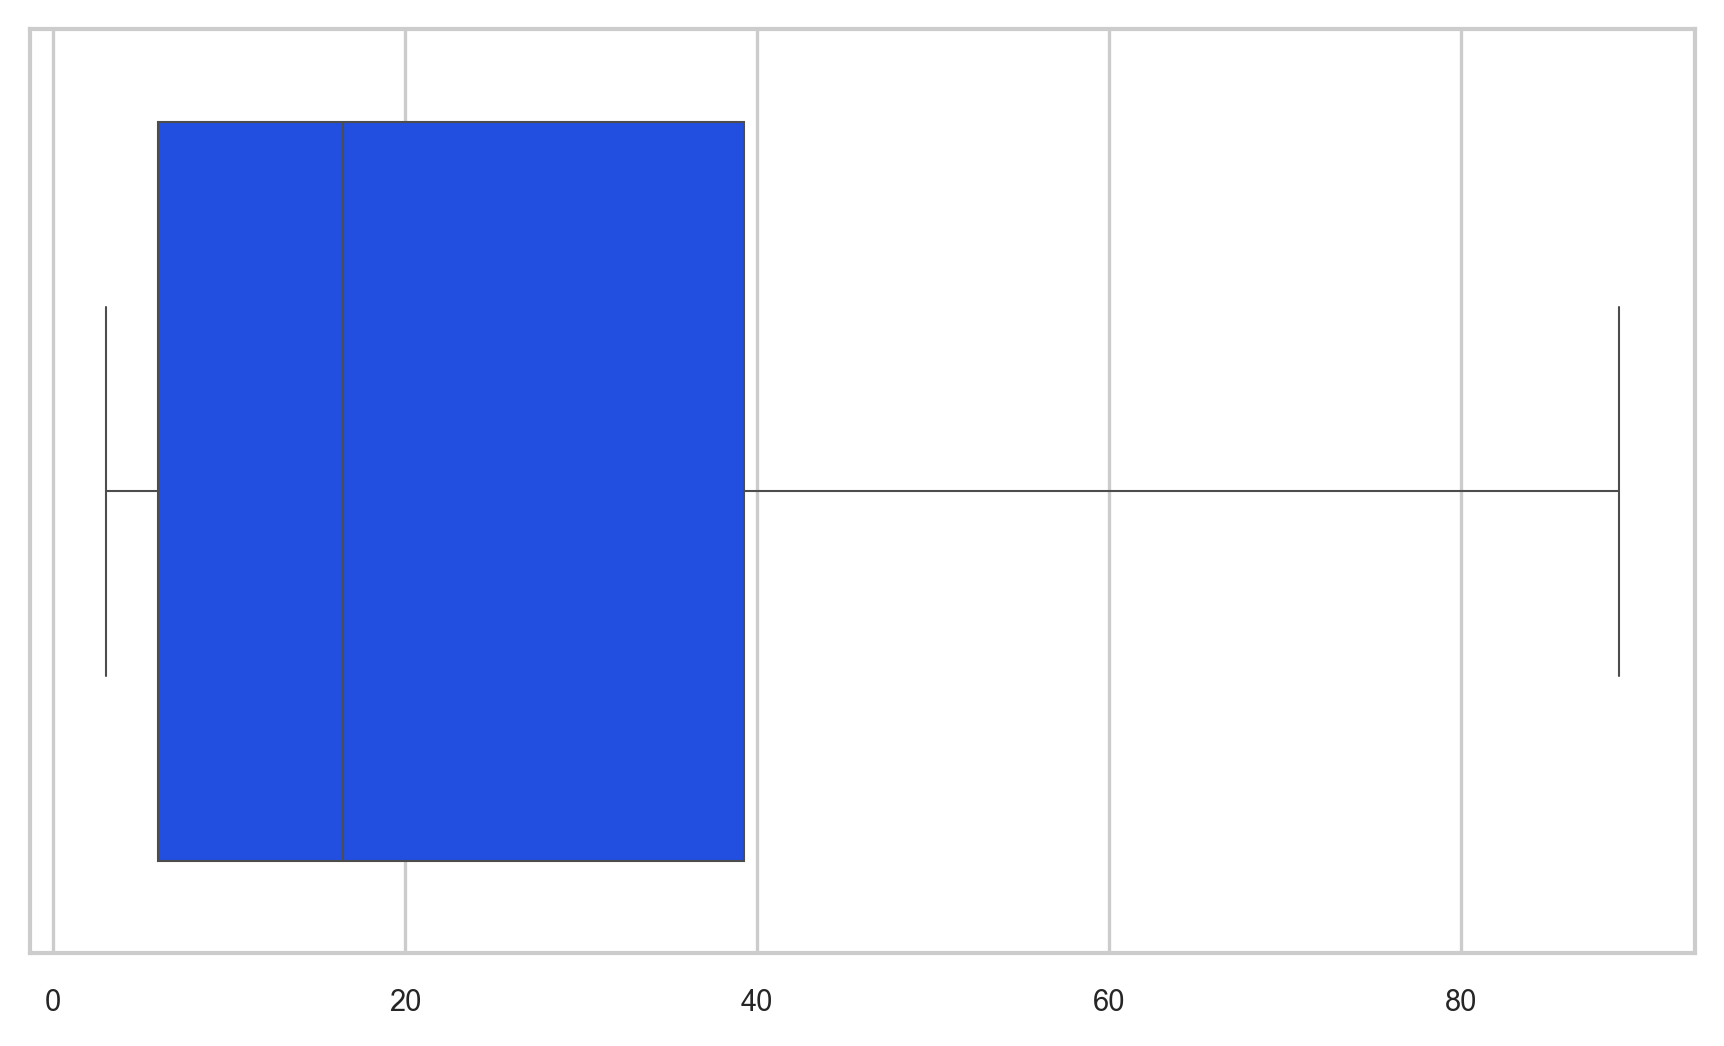

In [108]:
sns.boxplot(outage_freq.dt.total_seconds(), showfliers=False)

/home/sami/.local/share/virtualenvs/starlink-plot-RhHgxjja/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0'>

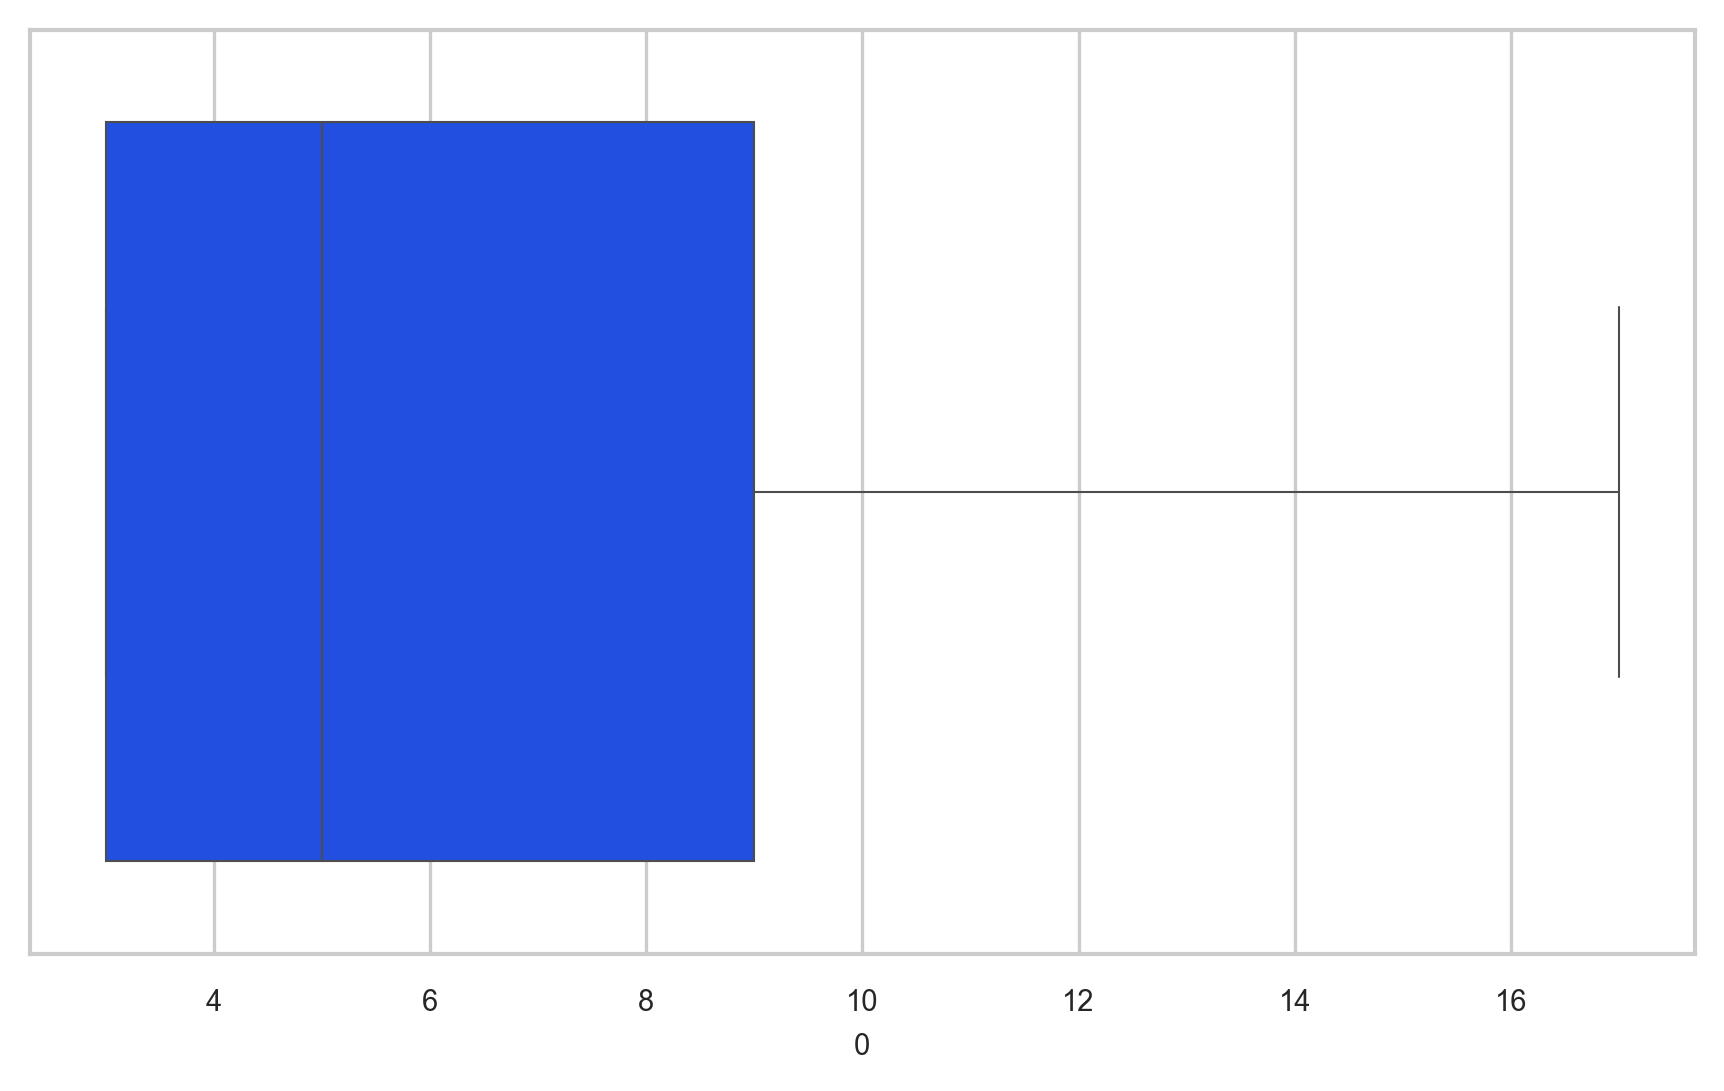

In [149]:
df_dddpd = pd.DataFrame(lst_diffs)
sns.boxplot(df_dddpd.iloc[:,0].dt.total_seconds(), showfliers=False)

In [40]:
df_old.pivot_table(index=N_TYPE, values=N_LATENCY)

,Latency (ms)
Type,
Starlink,201.111946
Terrestrial,183.833625


In [82]:
df.pivot_table(index=N_TYPE, values=N_LATENCY)

,Latency (ms)
Type,
Remote,233.170164


In [83]:
df.pivot_table(index=N_REGIONS, columns=N_TYPE, values=N_LATENCY)

Type,Remote
Regions,
Bahrain,272.429832
Cape Town,330.237123
London,189.877263
Mumbai,307.620074
N. California,77.890472
Sao Paulo,234.571725
Singapore,250.814257
Sydney,272.399077
Tokyo,162.831493


In [39]:
df_old[df_old[N_REGIONS] != 'N. California'].pivot_table(index=N_TYPE, values=N_LATENCY)

,Latency (ms)
Type,
Starlink,222.949606
Terrestrial,205.097495


In [38]:
df_old.pivot_table(index=N_REGIONS, columns=N_TYPE, values=N_LATENCY)

Type,Starlink,Terrestrial
Regions,,
Bahrain,266.696232,258.341745
Cape Town,310.377467,296.039889
London,168.085194,152.046133
Mumbai,284.594823,271.701787
N. California,55.383745,34.491404
Sao Paulo,213.843563,191.006578
Singapore,198.684958,196.848192
Sydney,230.887662,152.464079
Tokyo,151.918970,142.680309


In [210]:
df = df[df[N_TIMESTAMP] < '2022-07-21 21:10']
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df_high = df[df[N_LATENCY] > 200].sort_values(N_TIMESTAMP)
    print(df_high)
    print(df_high.groupby([pd.Grouper(key=N_TIMESTAMP, freq='1min')]).count())

      Latency (ms)                 Timestamp        Regions      Type
70           300.0 2022-07-21 20:40:56-07:00  N. California  Starlink
80           202.0 2022-07-21 20:41:07-07:00  N. California  Starlink
86           238.0 2022-07-21 20:41:13-07:00  N. California  Starlink
87           252.0 2022-07-21 20:41:14-07:00  N. California  Starlink
101          213.0 2022-07-21 20:41:28-07:00  N. California  Starlink
103          247.0 2022-07-21 20:41:30-07:00  N. California  Starlink
105          203.0 2022-07-21 20:41:32-07:00  N. California  Starlink
118         2825.0 2022-07-21 20:41:50-07:00  N. California  Starlink
126          495.0 2022-07-21 20:42:00-07:00  N. California  Starlink
128          206.0 2022-07-21 20:42:02-07:00  N. California  Starlink
132          304.0 2022-07-21 20:42:06-07:00  N. California  Starlink
332         1942.0 2022-07-21 20:46:18-07:00  N. California  Starlink
335          265.0 2022-07-21 20:46:20-07:00  N. California  Starlink
337          203.0 2

In [177]:
df = df[(df[N_TIMESTAMP] > '2022-07-17') & (df[N_TIMESTAMP] < '2022-07-18')]

3225     2022-07-16 19:02:07-07:00
3226     2022-07-16 19:02:08-07:00
3227     2022-07-16 19:02:11-07:00
3228     2022-07-16 19:02:13-07:00
3229     2022-07-16 19:02:15-07:00
                    ...           
239331   2022-07-16 21:18:04-07:00
239332   2022-07-16 21:18:05-07:00
239333   2022-07-16 21:18:06-07:00
239334   2022-07-16 21:18:07-07:00
239335   2022-07-16 21:18:08-07:00
Name: Timestamp, Length: 32093, dtype: datetime64[ns, US/Pacific]

In [74]:
df.groupby([N_REGIONS, N_TIMESTAMP]).mean().sort_values([N_REGIONS, N_TIMESTAMP])

Latency (ms)
Regions       Timestamp                        
N. California 2022-07-22 03:39:32          46.3
              2022-07-22 03:39:33          44.9
              2022-07-22 03:39:34          48.1
              2022-07-22 03:39:35          50.8
              2022-07-22 03:39:36          53.0
...                                         ...
              2022-07-22 04:56:36          41.3
              2022-07-22 04:56:37          50.4
              2022-07-22 04:56:38          43.4
              2022-07-22 04:56:39          43.1
              2022-07-22 04:56:40          44.5

[2175 rows x 1 columns]

In [8]:
#df_temp = combine_csvs(glob.glob(f'{src_dirs[1]}/US_West_N_California/*', recursive=True), 3, header=None)
#df_temp.index = pd.to_datetime(df_temp.index, unit='s')
#df_temp.sort_index()
#df.loc['2022-06-17 01']

In [15]:
# https://stackoverflow.com/questions/69300483/how-to-use-markers-with-ecdf-plot
def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

In [17]:
# Discern outliers
df_outliers = df_old
zscore = np.abs(df_outliers.groupby([
    N_TYPE, N_REGIONS])[N_LATENCY].transform(
    lambda x : stats.zscore(x, ddof=1, nan_policy='omit')
))
df_outliers[N_OUTLIERS] = (np.abs(zscore) >= 3)
df_outliers = df_outliers.sort_values(N_LATENCY)
df_outliers

#df_starlink_no_outliers = df_starlink[
#    (np.abs(stats.zscore(df_starlink[N_LATENCY], nan_policy='omit')) < 3.5)
#]
#df_no_outliers = pd.concat([df_starlink_no_outliers, df_home_no_outliers]).reset_index(drop=True)
#df_no_outliers

,Latency (ms),Timestamp,Regions,Type,Outliers
16151839,25.6,2022-06-02 06:54:10,N. California,Terrestrial,False
1457351,25.8,2022-04-19 03:54:36,N. California,Terrestrial,False
28980302,25.9,2022-06-08 04:50:04,N. California,Terrestrial,False
91957,25.9,2022-04-15 04:45:30,N. California,Terrestrial,False
53669735,25.9,2022-06-17 00:40:08,N. California,Terrestrial,False
...,...,...,...,...,...
5043008,13484.0,2022-05-11 21:06:27,Sao Paulo,Starlink,True
5043009,13524.0,2022-05-11 21:06:27,Sydney,Starlink,True
5043012,13572.0,2022-05-11 21:06:27,Singapore,Starlink,True
562526,13591.0,2022-04-16 13:33:57,Sydney,Starlink,True


In [118]:
df_combined = pd.concat([df_old, df_outliers])
print(df_combined.dtypes)
df_combined

Latency (ms)    float64
Timestamp        object
Regions          object
Type             object
Outliers           bool
dtype: object


,Latency (ms),Timestamp,Regions,Type,Outliers
0,57.4,2022-04-13 05:06:07,N. California,Starlink,False
1,47.8,2022-04-13 05:06:08,N. California,Starlink,False
2,61.9,2022-04-13 05:06:09,N. California,Starlink,False
3,52.9,2022-04-13 05:06:10,N. California,Starlink,False
4,51.0,2022-04-13 05:06:11,N. California,Starlink,False
...,...,...,...,...,...
730678,NaN,NaT,N. California,Remote,False
876529,NaN,NaT,Bahrain,Remote,False
1022904,NaN,NaT,Tokyo,Remote,False
1169136,NaN,NaT,London,Remote,False


In [16]:
#df_outliers = df_outliers.sort_values(N_TIMESTAMP)
#df_outliers.to_csv(os.path.join(out_path, '2022-06-17_end_all_ping_data.csv'), index=False)
#df_outliers.to_csv(os.path.join(out_path, '2022-06-21_end_koeye_ping_data.csv'), index=False)
#df_outliers[df_outliers[N_TIMESTAMP] > '2022-04-21']

df_filter = df_old
df_filter = df_filter[(df_filter[N_TIMESTAMP] > '2022-06-09') & (df_filter[N_TIMESTAMP] < '2022-06-17')]
df_filter = df_filter.sort_values(N_TIMESTAMP)

In [17]:
# Filter
#df_processed = df_outliers[df_outliers[N_OUTLIERS] == False]
#df_processed = df.loc['2022-05-13 07:13:50':'2022-05-13 7:14:18']
#df_processed = df.loc['2022-06-05':'2022-06-05 01']

#df_processing = df_outliers[df_outliers[N_TIMESTAMP] >= '2022-07-22 03:30']
#df_processing = df_old[df_old[N_OUTLIERS] == False]
df_processing = df_filter

df_processed = df_processing.groupby([N_TYPE, N_REGIONS]).resample('H', on=N_TIMESTAMP).mean()
df_processed = df_processed.reset_index()
#df_processed.to_csv('output/out.csv')
df_processed

,Type,Regions,Timestamp,Latency (ms),Outliers
0,Starlink,Bahrain,2022-06-09 00:00:00,297.905809,0.006768
1,Starlink,Bahrain,2022-06-09 01:00:00,295.867585,0.005342
2,Starlink,Bahrain,2022-06-09 02:00:00,294.665072,0.003096
3,Starlink,Bahrain,2022-06-09 03:00:00,297.849830,0.005373
4,Starlink,Bahrain,2022-06-09 04:00:00,300.016935,0.011572
...,...,...,...,...,...
3292,Terrestrial,Tokyo,2022-06-16 19:00:00,142.289766,0.000278
3293,Terrestrial,Tokyo,2022-06-16 20:00:00,142.859201,0.002702
3294,Terrestrial,Tokyo,2022-06-16 21:00:00,142.569686,0.002904
3295,Terrestrial,Tokyo,2022-06-16 22:00:00,142.914616,0.002605


In [67]:
#df_processed = df_processed.replace(np.NAN, np.inf)
#df_processed[df_processed[N_LATENCY] == np.inf].sort_values(N_TIMESTAMP)

,Type,Regions,Timestamp,Latency (ms),Outliers
4202,Terrestrial,N. California,2022-06-06 02:00:00,inf,inf
5438,Terrestrial,Tokyo,2022-06-06 02:00:00,inf,inf
3275,Terrestrial,Cape Town,2022-06-06 02:00:00,inf,inf
3893,Terrestrial,Mumbai,2022-06-06 02:00:00,inf,inf
4511,Terrestrial,Sao Paulo,2022-06-06 02:00:00,inf,inf
...,...,...,...,...,...
308,Starlink,Bahrain,2022-06-16 05:00:00,inf,inf
628,Starlink,Cape Town,2022-06-16 05:00:00,inf,inf
309,Starlink,Bahrain,2022-06-16 06:00:00,inf,inf
310,Starlink,Bahrain,2022-06-16 07:00:00,inf,inf


In [22]:
df[(df[N_REGIONS] == 'Sydney') & (df[N_TYPE] == N_STARLINK)]

,Latency (ms),Timestamp,Regions,Type,Outliers


In [ ]:
df_regs_interp = df_processed.interpolate(method='linear')
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,41,1))
df_regs_interp

In [16]:
df_cdf = df_processed[df_processed[N_OUTLIERS] == False].groupby([N_TYPE, N_REGIONS])[N_LATENCY].apply(ecdf, False)
#df_cdf = df_processed.value_counts().sort_index().cumsum() * 1./len(df_processed)
df_cdf = df_cdf.reset_index().drop('level_2', axis=1)
df_cdf

,Type,Regions,x,y
0,Starlink,Bahrain,242.489994,0.018868
1,Starlink,Bahrain,243.396581,0.037736
2,Starlink,Bahrain,243.546831,0.056604
3,Starlink,Bahrain,243.577063,0.075472
4,Starlink,Bahrain,243.593974,0.094340
...,...,...,...,...
2083,Terrestrial,Tokyo,142.943008,0.948052
2084,Terrestrial,Tokyo,143.043647,0.961039
2085,Terrestrial,Tokyo,143.072423,0.974026
2086,Terrestrial,Tokyo,143.215239,0.987013


In [ ]:
#df_pivot = df_unstacked.pivot_table(index=[N_REGIONS, 'timestamp'], columns='type', values='latency')
#print(df_pivot.head())

g = sns.catplot(data=df_unstacked, x='type', y='latency', col=N_REGIONS, col_wrap=4, kind='box', height=2,
        aspect=0.895, showfliers=True)
g.set(yscale='log')
g.tight_layout()
(g.set_axis_labels('Provider', 'Latency (ms)')
        .set_titles("{col_name}"))

In [47]:
df_processed[df_processed[N_LATENCY] == np.inf]

,Type,Regions,Timestamp,Latency (ms),Outliers
211,Dish A,Bahrain,2022-06-12 04:00:00,inf,inf
212,Dish A,Bahrain,2022-06-12 05:00:00,inf,inf
213,Dish A,Bahrain,2022-06-12 06:00:00,inf,inf
214,Dish A,Bahrain,2022-06-12 07:00:00,inf,inf
223,Dish A,Bahrain,2022-06-12 16:00:00,inf,inf
...,...,...,...,...,...
5518,Terrestrial,Tokyo,2022-06-09 10:00:00,inf,inf
5519,Terrestrial,Tokyo,2022-06-09 11:00:00,inf,inf
5520,Terrestrial,Tokyo,2022-06-09 12:00:00,inf,inf
5521,Terrestrial,Tokyo,2022-06-09 13:00:00,inf,inf


In [111]:
tt = df_filter
tt = tt[(tt[N_TIMESTAMP] > '2022-06-12 04:00') & (tt[N_TIMESTAMP] < '2022-06-12 05:00')]
tt[(tt[N_REGIONS] == 'Bahrain') & (tt[N_TYPE] == N_STARLINK)]


,Latency (ms),Timestamp,Regions,Type,Outliers


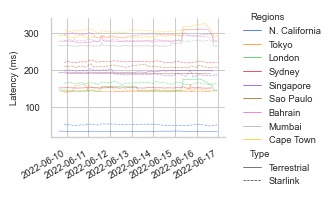

In [22]:
import datetime as dt
#fig, ax = plt.subplots(figsize=(7.16,4), dpi=100)
#fig, ax = plt.subplots(figsize=(20,10))
# 6.09 for full size, 2.5 for half size

#df_time = df[df[N_TIMESTAMP] < '2022-07-22 04:10']

#df_time = df_processed[df_processed[N_TIMESTAMP] > '2022-06-03']

#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-07-22 03:30')]
#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-06-17 08:29') & (df_time[N_TIMESTAMP] < '2022-06-17 08:32')]
#df_time = df_time[df_time[N_REGIONS] == 'Cape Town']

df_time = df_processed
df_time = df_time[df_time[N_OUTLIERS] == False]
#df_time = df_time[(df_time[N_TIMESTAMP] > '2022-06-12') & (df_time[N_TIMESTAMP] < '2022-06-12 10:00:00')]
#df_time = df_time[df_time[N_REGIONS] == 'Bahrain']

h = 1.9
#df_time = df_time.replace(N_STARLINK, N_DISHA)
aspect = (common.WIDTH_HALF - 1) / h
#aspect = 6 / h

#df_time = df_time[df_time[N_REGIONS] == 'N. California']
g_time = sns.relplot(data=df_time, 
                     x=N_TIMESTAMP, y=N_LATENCY, 
                     hue=N_REGIONS, 
                     #hue_order=['N. California', 'N. Virginia', 'Sydney'],
                     hue_order=REGION_ORDER,
                     height=h, aspect=aspect,
                     kind='line',
                     #palette=['C0', 'C1', 'C3'],
                     #col=N_TYPE, col_order=[N_DISHA, N_HOME],
                     style=N_TYPE, style_order=[N_HOME, N_STARLINK],
                     alpha=0.5,
                    )

axes = g_time.axes.flatten()
df_missing = df_time[(df_time[N_LATENCY].isnull()) & (df_time[N_TYPE] == N_STARLINK)]
pal = sns.color_palette('bright')
for ax in axes:
    #ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    #ax.set_rasterized(True)
    #for _, row in df_missing.iterrows():
    #    ax.axvline(row[N_TIMESTAMP], alpha=0.1, ls='--', color='red')
    
    prev_timestamp = None
    #for _, row in df_missing.iterrows():
    #    if prev_timestamp:
    #        if (row[N_TIMESTAMP] - prev_timestamp) > pd.Timedelta(hours=1):
    #            ind = common.REGION_ORDER.index(row[N_REGIONS])
    #            ax.axvspan(prev_timestamp, row[N_TIMESTAMP], alpha=0.1,
    #                       facecolor='red',
    #                       #facecolor=pal[ind],
    #                       ec='white', ls='--')
    #            prev_timestamp = None
    #    else:
    #        prev_timestamp = row[N_TIMESTAMP]
    
g_time.set(
    #yscale='log',
    xlabel=''
)

g_time.figure.autofmt_xdate()
g_time.tight_layout()

In [23]:
g_time.savefig(f'{OUT_PATH}/2022-06-03_and_06_hourly_ping_no_outliers.pdf', bbox_inches='tight')
#fig.savefig(f'{filename}.pgf', bbox_inches='tight')

/tmp/ipykernel_537219/3591534955.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['datenum'] = dates.date2num(df_time[N_TIMESTAMP])


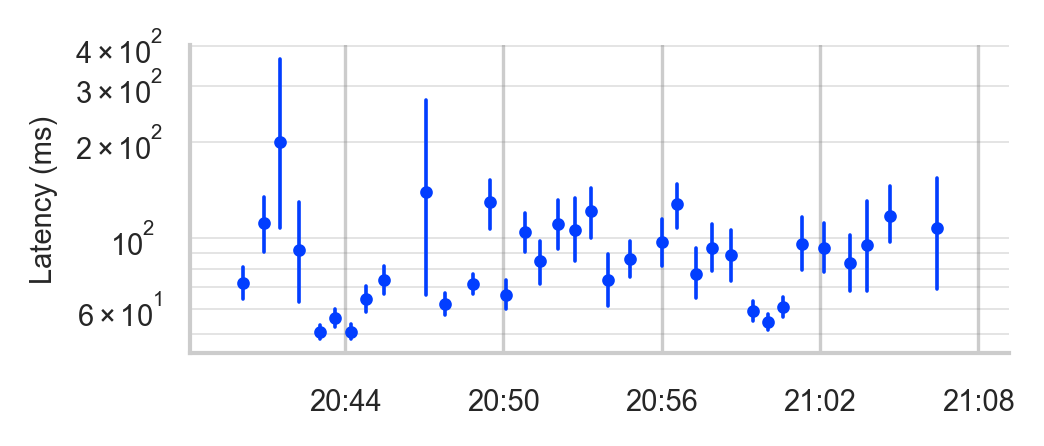

In [190]:
#fig, ax = plt.subplots(figsize=(7.16,4), dpi=100)
#fig, ax = plt.subplots(figsize=(20,10))
# 6.09 for full size, 2.5 for half size

df_time = df[df[N_TIMESTAMP] < '2022-07-21 21:10']

#df_time = df_processed.set_index(N_TIMESTAMP)['2022-06-03':].reset_index()
#df_time = df_time[df_time[N_OUTLIERS] == False]

#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-07-22 03:30')]
#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-06-17 08:29') & (df_time[N_TIMESTAMP] < '2022-06-17 08:32')]
#df_time = df_time[df_time[N_REGIONS] == 'Cape Town']

df_time['datenum'] = dates.date2num(df_time[N_TIMESTAMP])

@pyplot.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into datetime"""
    return dates.num2date(x, tz=pytz.timezone('US/Pacific')).strftime('%H:%M')

h = 1.5
aspect = (common.WIDTH_HALF) / h
#aspect = 6 / h

df_time = df_time[df_time[N_REGIONS] == 'N. California']
g_time = sns.lmplot(data=df_time,
                     x='datenum', y=N_LATENCY, 
                     #hue=N_REGIONS, 
                     #hue_order=['N. California', 'N. Virginia', 'Sydney'],
                     #hue_order=REGION_ORDER,
                     height=h, aspect=aspect,
                     #kind='line',
                     #palette=['C0', 'C1', 'C3'],
                     #style=N_TYPE, style_order=[N_HOME, N_STARLINK],
                    #x_ci=95,
                    fit_reg=False,
                     scatter_kws=dict(s=5),
                    x_bins=35,
                    )

axes = g_time.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    ax.xaxis.set_major_locator(dates.MinuteLocator(range(2,60,6)))
    ax.xaxis.set_major_formatter(fake_dates)
    
g_time.set(yscale='log',
          xlabel='')

#g_time.figure.autofmt_xdate()
g_time.tight_layout()

In [262]:
df_old[N_REGIONS] = pd.Categorical(df_old[N_REGIONS], categories=common.REGION_ORDER)
df_old = df_old.sort_values(N_REGIONS)
df_old

/home/sami/.local/share/virtualenvs/starlink-plot-RhHgxjja/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


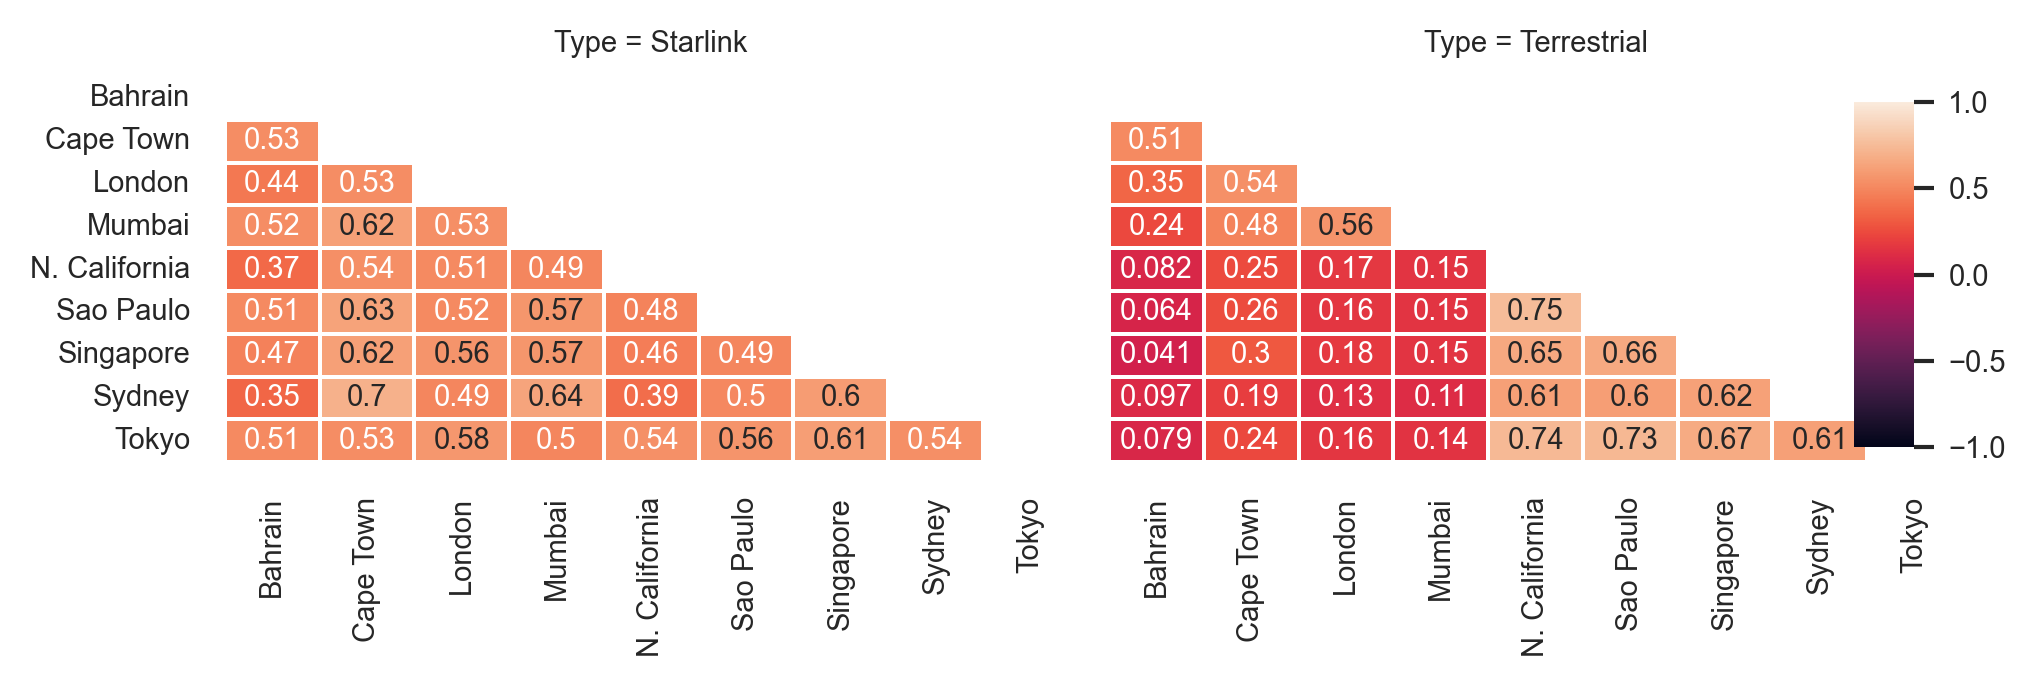

In [94]:
### Correlation Heatmap

#df_reg_corr = df[df[N_TIMESTAMP] < '2022-07-21 21:10']
df_reg_corr = df_old

#df_reg_corr = df_reg_corr[df_reg_corr[N_REGIONS] == 'N. California']

#df_time = df_processed.set_index(N_TIMESTAMP)['2022-06-03':].reset_index()
#df_time = df_time[df_time[N_OUTLIERS] == False]

#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-07-22 03:30')]
#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-06-17 08:29') & (df_time[N_TIMESTAMP] < '2022-06-17 08:32')]
#df_time = df_time[df_time[N_REGIONS] == 'Cape Town']

keep_cols = ['Throughput', 'Jitter (ms)', 'Lost %', 'Temp (°C)',
             'Dew Point (°C)', 'Rel Hum (%)', 'Precip. (mm)']
def draw_corr(*args, **kwargs):
    df = kwargs.pop('data')
    df = df.pivot_table(index=N_TIMESTAMP, columns=N_REGIONS, values=N_LATENCY)
    #corr = df[keep_cols]
    corr = df.corr()
    #corr = corr.drop(keep_cols[3:], axis=1)
    #corr = corr.dropna(how='all')
    #corr = corr.drop(keep_cols[0], axis=0)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, **kwargs)

h = 2.3
row = len(df_reg_corr[N_TYPE].unique())
aspect = (common.WIDTH_FULL - .5) / row / h
#aspect = 6 / h

g_corr_map = sns.FacetGrid(
    data=df_reg_corr,
    col=N_TYPE,
    aspect=aspect,
    height=h,
    sharey='row',
)
cbar_ax = g_corr_map.figure.add_axes([.93, .35, .03, .5])
g_corr_map.map_dataframe(
    draw_corr, 
    linewidths=.5,
    vmin=-1, vmax=1,
    cbar_ax=cbar_ax,
    #cbar_kws={"shrink": .5},
    annot=True,
)

axes = g_corr_map.axes.flatten()
#for ax in axes:
#    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
#    ax.xaxis.set_major_locator(dates.MinuteLocator(range(2,60,6)))
#    ax.xaxis.set_major_formatter(fake_dates)

#g_time.figure.autofmt_xdate()
g_corr_map.set(xlabel='', ylabel='')
g_corr_map.tight_layout()

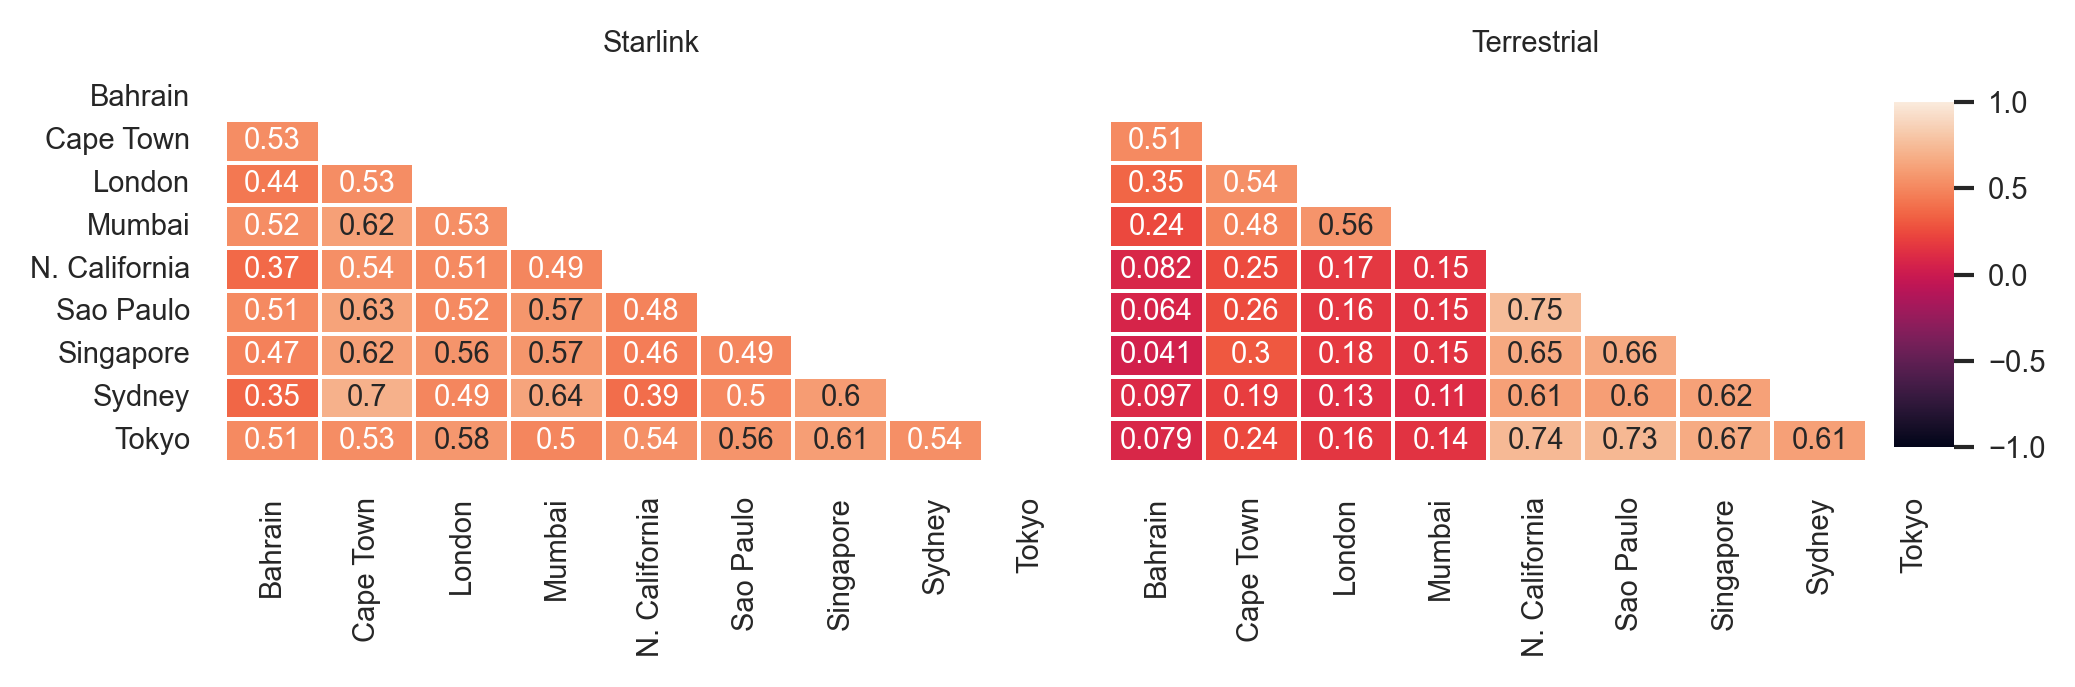

In [95]:
g_corr_map.set_titles(col_template="{col_name}")
cbar_ax.set_position([.95, .35, .03, .5])
g_corr_map.figure

In [96]:
g_corr_map.savefig(f'{OUT_PATH}/2022-06_17_region_corr.pdf', bbox_inches='tight')

In [240]:
from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = pearsonr(df[r], df[c])[1]
    return pvalues

In [ ]:
### P-value Correlation Heatmap

#df_reg_corr = df[df[N_TIMESTAMP] < '2022-07-21 21:10']
df_reg_corr = df_old

#df_reg_corr = df_reg_corr[df_reg_corr[N_REGIONS] == 'N. California']

#df_time = df_processed.set_index(N_TIMESTAMP)['2022-06-03':].reset_index()
#df_time = df_time[df_time[N_OUTLIERS] == False]

#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-07-22 03:30')]
#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-06-17 08:29') & (df_time[N_TIMESTAMP] < '2022-06-17 08:32')]
#df_time = df_time[df_time[N_REGIONS] == 'Cape Town']

keep_cols = ['Throughput', 'Jitter (ms)', 'Lost %', 'Temp (°C)',
             'Dew Point (°C)', 'Rel Hum (%)', 'Precip. (mm)']
def draw_corr(*args, **kwargs):
    df = kwargs.pop('data')
    df = df.pivot_table(index=N_TIMESTAMP, columns=N_REGIONS, values=N_LATENCY)
    #corr = df[keep_cols]
    corr = calculate_pvalues(df)
    print(corr)
    #corr = corr.drop(keep_cols[3:], axis=1)
    #corr = corr.dropna(how='all')
    #corr = corr.drop(keep_cols[0], axis=0)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, **kwargs)

h = 2.3
aspect = (common.WIDTH_HALF) / h
#aspect = 6 / h

g_pval = sns.FacetGrid(
    data=df_reg_corr,
    #col=COL_TRANSF_DIR,
    #row=N_PROTOCOL,
    aspect=aspect,
    height=h,
    sharey='row',
)
cbar_ax = g_pval.figure.add_axes([.93, .35, .03, .5])
g_pval.map_dataframe(
    draw_corr, 
    linewidths=.5,
    vmin=-1, vmax=1,
    cbar_ax=cbar_ax,
    #cbar_kws={"shrink": .5},
    annot=True,
)

axes = g_pval.axes.flatten()
#for ax in axes:
#    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
#    ax.xaxis.set_major_locator(dates.MinuteLocator(range(2,60,6)))
#    ax.xaxis.set_major_formatter(fake_dates)

#g_time.figure.autofmt_xdate()
g_pval.set(xlabel='', ylabel='')
g_pval.tight_layout()

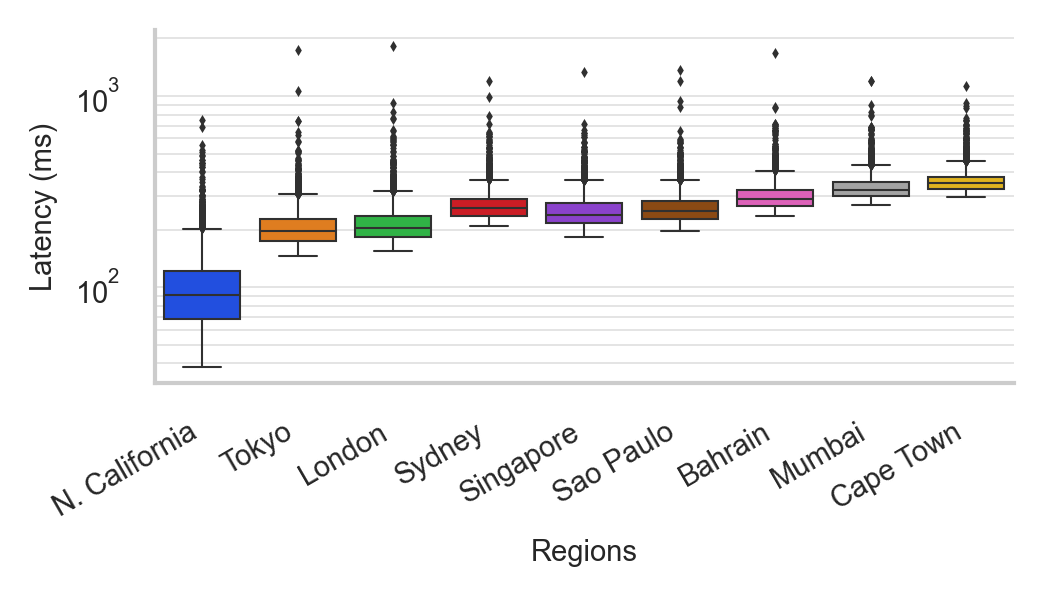

In [178]:
#fig, ax = plt.subplots(figsize=(7.16,4), dpi=100)
#fig, ax = plt.subplots(figsize=(20,10))
# 6.09 for full size, 2.5 for half size

#df_time = df_processed.set_index(N_TIMESTAMP)['2022-06-03':].reset_index()
#df_time = df_time[df_time[N_OUTLIERS] == False]

#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-07-22 03:30')]
#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-06-17 08:29') & (df_time[N_TIMESTAMP] < '2022-06-17 08:32')]
#df_time = df_time[df_time[N_REGIONS] == 'Cape Town']

h = 2
aspect = (common.WIDTH_HALF) / h
#aspect = 6 / h
order = common.REGION_ORDER.copy()
order.remove('N. Virginia')

#df_time = df_time[df_time[N_REGIONS] == 'N. California']
g_time = sns.catplot(data=df, 
                     x=N_REGIONS, y=N_LATENCY, 
                     order=order,
                     hue=N_REGIONS, hue_order=order,
                     #hue_order=['N. California', 'N. Virginia', 'Sydney'],
                     #hue_order=REGION_ORDER,
                     height=h, aspect=aspect,
                     kind='box',
                     #palette=['C0', 'C1', 'C3'],
                     dodge=False,
                     fliersize=0.5,
                    )

axes = g_time.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
g_time.set(yscale='log')

g_time.figure.autofmt_xdate()
g_time.tight_layout()

In [191]:
#g_time.savefig(f'{OUT_PATH}/2022-06-03_and_06_12hourly_ping.pdf', bbox_inches='tight')
#g_time.savefig(f'{OUT_PATH}/2022-06-03_and_06_hourly_ping_no_outliers.pdf', bbox_inches='tight')
#g_time.savefig(f'{OUT_PATH}/2022-07_17_starlink_campground_ping_time.pdf', bbox_inches='tight')
g_time.savefig(f'{OUT_PATH}/2022-07_21_starlink_mobility_ping_time.pdf', bbox_inches='tight')

In [17]:
df_sample = df_outliers[df_outliers[N_OUTLIERS] == False]
df_sample = df_sample.pivot_table(
    index=[N_REGIONS,N_TIMESTAMP],
    columns=N_TYPE,
    values=N_LATENCY,
    #aggfunc={N_LATENCY: np.mean,
    #         N_OUTLIERS: np.logical_or}
).reset_index()
#df_outliers_type = df_outliers[df_outliers[N_OUTLIERS] == True]
#df_outliers_type = df_outliers_type.pivot_table(index=[N_OUTLIERS, N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()

# https://stackoverflow.com/questions/39457762/python-pandas-conditionally-select-a-uniform-sample-from-a-dataframe
df_sample = df_sample.groupby([N_REGIONS]).sample(20000)
#df_sample = pd.concat([df_sample, df_outliers_type]).reset_index(drop=True)
df_sample

Type,Regions,Timestamp,Home,Starlink
879051,Bahrain,2022-06-03 12:58:01,NaN,237.0
1411656,Bahrain,2022-06-09 19:54:49,277.0,296.0
159881,Bahrain,2022-05-11 05:05:23,230.0,230.0
1853238,Bahrain,2022-06-14 22:38:15,280.0,NaN
772115,Bahrain,2022-06-01 05:33:25,263.0,241.0
...,...,...,...,...
18179443,Tokyo,2022-06-08 06:10:52,144.0,141.0
16943939,Tokyo,2022-05-09 19:56:44,143.0,160.0
18657062,Tokyo,2022-06-13 19:25:03,144.0,133.0
17096964,Tokyo,2022-05-11 14:27:15,140.0,164.0


In [15]:
df_std = df_old.groupby([N_TYPE, N_REGIONS]).std().reset_index()
df_std

,Type,Regions,Latency (ms),Outliers
0,Starlink,Bahrain,42.688723,0.069635
1,Starlink,Cape Town,33.584442,0.082230
2,Starlink,London,32.744511,0.081066
3,Starlink,Mumbai,35.171968,0.073151
4,Starlink,N. California,30.772301,0.078465
5,Starlink,Sao Paulo,34.875162,0.076604
6,Starlink,Singapore,33.897127,0.074623
7,Starlink,Sydney,34.034000,0.068830
8,Starlink,Tokyo,37.424559,0.070320
9,Terrestrial,Bahrain,31.816236,0.057079


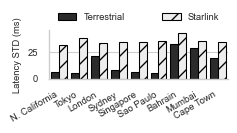

In [61]:
df_t = df_std

sns.set_palette('Greys_r')
h = 1.4
aspect = (common.WIDTH_HALF - 1) / h
g_std = sns.catplot(
    data=df_t,
    x=N_REGIONS, y=N_LATENCY,
    hue=N_TYPE, hue_order=[N_HOME, N_STARLINK],
    order=REGION_ORDER,
    kind='bar',
    palette=['C0', 'C5'],
    height=h,
    aspect=aspect,
    legend=False,
)

axes = g_std.axes.flatten()
num_locs = len(df_t[N_REGIONS].unique())
hatches = itertools.cycle(['', '//'])
#g_avg.set(yscale='log')
for ax in axes:
    #ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    #ax.set(xticks=[])
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
        
g_std.set_titles(col_template="{col_name}")
axes[0].legend(loc='lower center', bbox_to_anchor=(0,1,1,0.2),
               ncol=2, mode='expand',
               #fancybox=True, 
               frameon=False,
              )
g_std.set(ylabel='Latency STD (ms)', xlabel='')
g_std.figure.autofmt_xdate()
g_std.tight_layout()

In [62]:
g_std.savefig(f'{OUT_PATH}/2022-06-17_end_ping_std.pdf', bbox_inches='tight')
#fig.savefig(f'{filename}.pgf', bbox_inches='tight')

In [ ]:
t = df_sample.dropna()
#t[t[N_OUTLIERS] == True]
t.sort_values(N_TIMESTAMP)

In [ ]:
df_out_sample = df_sample[df_sample[N_OUTLIERS] == True]
df_out_sample.sort_values([N_STARLINK, N_HOME]).to_csv(f'{out_path}/outliers.csv')

In [ ]:
#df_home_no_out = df_outliers[(df_outliers[N_TYPE] == N_HOME) & (df_outliers[N_LATENCY] < 1000)]
df_home_no_out = df_outliers[(df_outliers[N_TYPE] == N_HOME) & (df_outliers[N_OUTLIERS] == False)].copy()
df_star = df_outliers[df_outliers[N_TYPE] == N_STARLINK].copy()
df_all = pd.concat([df_home_no_out, df_star])
df_all = df_all.pivot_table(index=[N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()
df_all

In [ ]:
#df_all[df_all[N_HOME] > 1000]
#df_star[df_star[N_LATENCY] > 1000]

In [ ]:
#df_type = df_processed.pivot_table(index=[N_OUTLIERS, N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()
df_type = df_all
#df_type = df_type.dropna(subset=[N_HOME, N_STARLINK])
h = 1.5
aspect = (common.WIDTH_HALF - 1) / h
g_scatter = sns.lmplot(
    data=df_type,
    #col=N_OUTLIERS,
    x_bins=10,
    #x_ci='sd',
    #ci=None,
    x=N_HOME, y=N_STARLINK,
    hue=N_REGIONS, hue_order=REGION_ORDER,
    palette='bright',
    facet_kws={'sharex': False, 'sharey': False},
    scatter_kws={'s': 5, 'linewidth': 0},
    #markers='x',
    #scatter=False,
    height=h,
    aspect=aspect,
)
#g_scatter = sns.displot(data=df_type[df_type[N_OUTLIERS] == False], x=N_HOME, y=N_STARLINK,
#                        binwidth=10, 
#                        hue=N_REGIONS, facet_kws={'sharex': False, 'sharey': False},
#                       height=3, palette='colorblind')

axes = g_scatter.axes.flatten()
#for ax in axes:
#    x0, x1 = ax.get_xlim()
#    y0, y1 = ax.get_ylim()
#    lims = [max(x0, y0), min(x1, y1)]
#    ax.plot(lims, lims, '-r')
#axes[1].set(yscale='log', xscale='log')
#g_scatter.set_titles(col_template="{col_name}")
g_scatter.tight_layout()

In [70]:
g_scatter.savefig(f'{OUT_PATH}/2022-06-17_end_all_ping_regression_no_outliers.pdf', bbox_inches='tight')

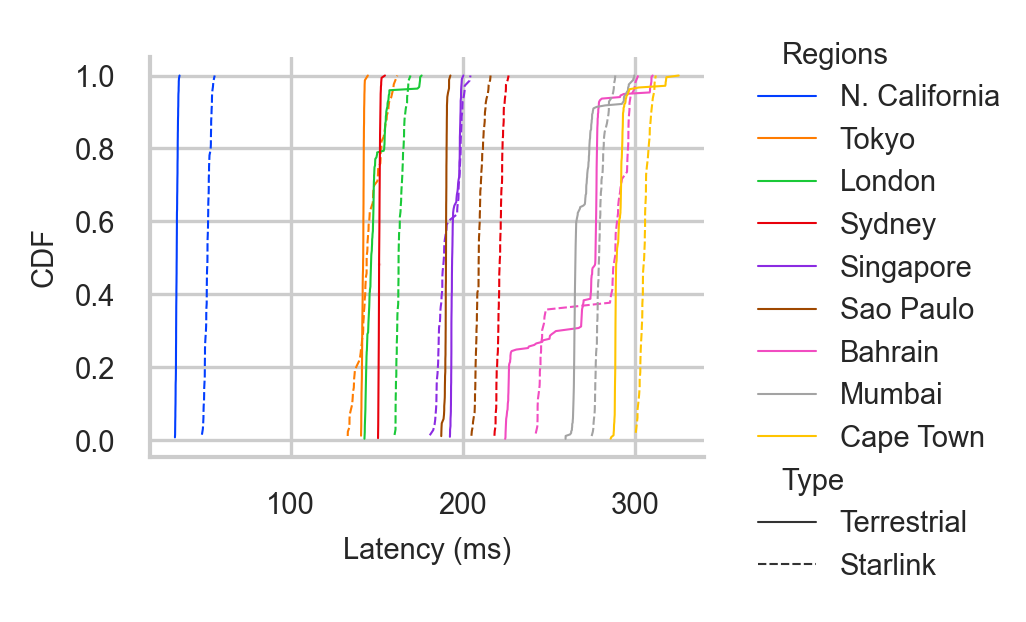

In [21]:
#fig, ax =df_sampleubplots(figsize=(3.5,2))
#fig, ax = plt.subplots(figsize=(7.16,2.5))
#fig_cdf, ax_cdf = plt.subplots(figsize=(7.16,2.5))

h = 1.9
aspect = (common.WIDTH_HALF - 1) / h

#g = sns.ecdfplot(data=df_unstacked, x='latency', hue='Type Region', ax=ax)
g_cdf = sns.relplot(data=df_cdf, x='x', y='y', hue=N_REGIONS, 
                    style=N_TYPE, style_order=[N_HOME, N_STARLINK],
                hue_order=REGION_ORDER, kind='line', palette='bright',
                height=h, aspect=aspect)
#g.set(xscale='log')
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g_cdf.set(xlabel='Latency (ms)', ylabel='CDF')
g_cdf.tight_layout()

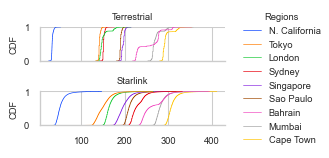

In [14]:
#fig, ax =df_sampleubplots(figsize=(3.5,2))
#fig, ax = plt.subplots(figsize=(7.16,2.5))
#fig_cdf, ax_cdf = plt.subplots(figsize=(7.16,2.5))

h = 0.8
aspect = (common.WIDTH_HALF - 1) / h

df_cdf = df_old
df_cdf = df_cdf[df_cdf[N_OUTLIERS] == False]

#g = sns.ecdfplot(data=df_unstacked, x='latency', hue='Type Region', ax=ax)
g_cdf = sns.displot(data=df_cdf, x=N_LATENCY, hue=N_REGIONS, 
                    row=N_TYPE, row_order=[N_HOME, N_STARLINK],
                hue_order=REGION_ORDER, kind='ecdf', palette='bright',
                height=h, aspect=aspect)
#g.set(xscale='log')
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g_cdf.set(xlabel='', ylabel='CDF')
g_cdf.set_titles(row_template='{row_name}')
g_cdf.tight_layout()

In [1]:
#g_cdf.refline(y=0.95)
g_cdf.tight_layout()
g_cdf.figure

NameError: name 'g_cdf' is not defined

In [15]:
g_cdf.savefig(f'{OUT_PATH}/2022-06-17_end_all_ping_cdf_smaller.pdf', bbox_inches='tight')
#fig.savefig(f'{filename}.pgf', bbox_inches='tight')

/tmp/ipykernel_2217073/1501506479.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['label_type'] = df_temp[N_TYPE].map(dict(zip(old, new)))


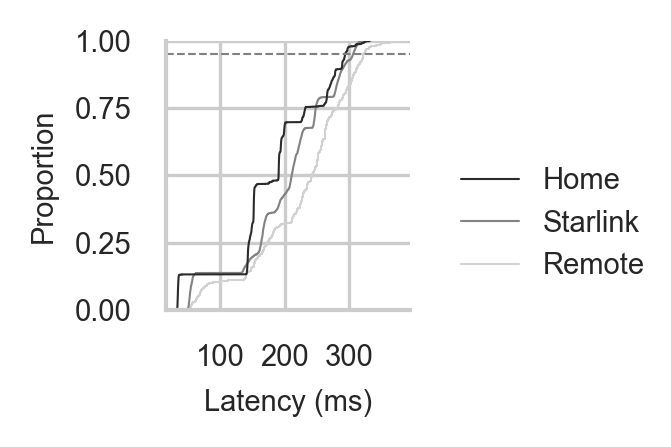

In [73]:
#_, ax_hist = plt.subplots(figsize=(7.16,4), dpi=300)
h = 1.5
aspect = (WIDTH_THIRD - 0.7) / h

old = ['Home', 'Starlink', 'Starlink Remote']
new = ['Home', 'Starlink', 'Remote']
df_temp = df_processed[df_processed[N_OUTLIERS] == False]
df_temp['label_type'] = df_temp[N_TYPE].map(dict(zip(old, new)))

sns.set_palette('Greys_r')
g_hist_single = sns.displot(
    data=df_temp, 
    x=N_LATENCY, 
    #row='label_type', 
    #hue=N_REGIONS, hue_order=common.REGION_ORDER,
    hue='label_type', hue_order=new,
    #hue=N_TYPE, 
    palette=['C0', 'C2', 'C4'],
    kind='ecdf', height=h, aspect=aspect)
#g_hist_single.figure.autofmt_xdate()
sns.move_legend(g_hist_single, loc='center right', title='')
axes = g_hist_single.axes.flatten()
#for label in axes[2].get_xticklabels():
#    label.set_rotation(90)
g_hist_single.refline(y=0.95)
g_hist_single.set_titles(row_template="{row_name}")
#g_hist_single.set(ylabel='')
#g_hist_single.figure.supylabel('Proportion')
g_hist_single.tight_layout()


In [74]:
g_hist_single.savefig(f'{OUT_PATH}/2022-06-21_koeye_ping_cdf.pdf', bbox_inches='tight')

/tmp/ipykernel_2217073/1729835221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['label_type'] = df_temp[N_TYPE].map(dict(zip(old, new)))


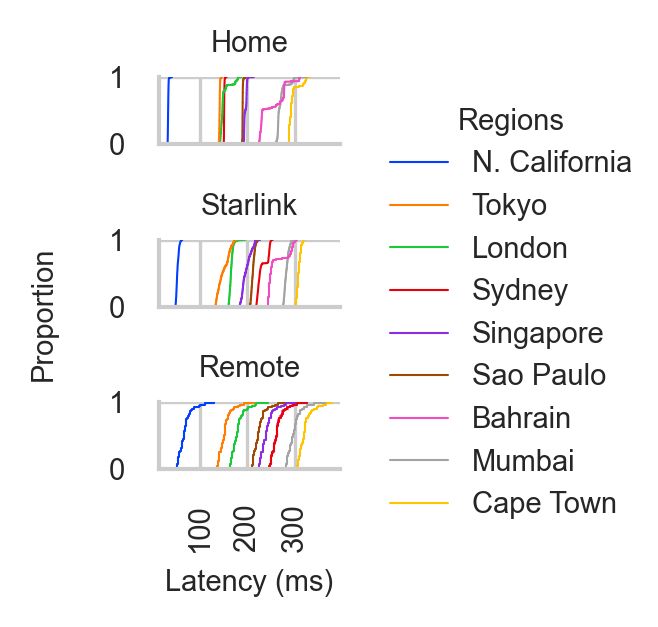

In [54]:
#_, ax_hist = plt.subplots(figsize=(7.16,4), dpi=300)
h = 0.7
aspect = (WIDTH_THIRD - 1) / h

old = ['Home', 'Starlink', 'Starlink Remote']
new = ['Home', 'Starlink', 'Remote']
df_temp = df_processed[df_processed[N_OUTLIERS] == False]
df_temp['label_type'] = df_temp[N_TYPE].map(dict(zip(old, new)))

g_hist = sns.displot(
    data=df_temp, 
    x=N_LATENCY, 
    row='label_type', 
    hue=N_REGIONS, hue_order=common.REGION_ORDER,
    #hue=N_TYPE, 
    palette='bright',
    kind='ecdf', height=h, aspect=aspect)
#g_hist.figure.autofmt_xdate()
axes = g_hist.axes.flatten()
for label in axes[2].get_xticklabels():
    label.set_rotation(90)
g_hist.set_titles(row_template="{row_name}")
g_hist.set(ylabel='')
g_hist.figure.supylabel('Proportion')
g_hist.tight_layout()


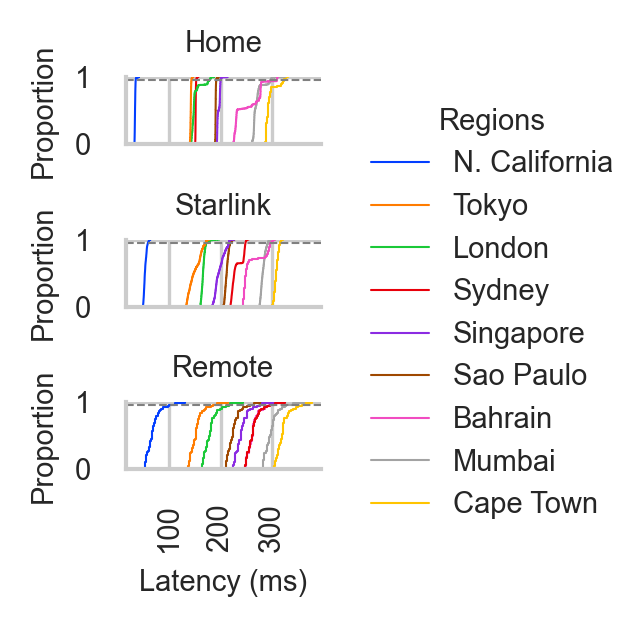

In [51]:
#g_hist.refline(y=0.9)
g_hist.refline(y=0.95)
#g_hist.refline(y=0.99)
g_hist.set_titles(row_template="{row_name}")
g_hist.tight_layout()

In [55]:
g_hist.savefig(f'{OUT_PATH}/2022-06-21_koeye_ping_cdf.pdf', bbox_inches='tight')

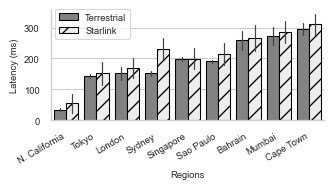

In [63]:
#temp = df_regs.loc['2022-06-03':]

#df_averaged = df.groupby([N_TYPE, N_REGIONS]).std().reset_index()

#styler = df_averaged.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_avg_bandwidth.tex'))
h=2
aspect = common.WIDTH_HALF / h

sns.set_palette('Greys')
#df_samp = df_combined.groupby([N_REGIONS]).sample(10000)
df_temp = df_old
g_avg = sns.catplot(data=df_temp,
                    sharey=False,
                    x=N_REGIONS, y=N_LATENCY, hue=N_TYPE,
                    hue_order=[N_HOME, N_STARLINK],
                    order=REGION_ORDER,
                    legend=False,
                    kind='bar',
                    palette=['C9', 'C0'],
                    ci='sd',
                    height=h, aspect=aspect)

num_locs = len(df_temp[N_REGIONS].unique())
hatches = itertools.cycle(['', '//'])
axes = g_avg.axes.flatten()
for ax in axes:
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
        
g_avg.figure.autofmt_xdate()
axes[0].legend(loc='upper left', bbox_to_anchor=(0,1.04))
g_avg.set_titles(row_template="{row_name}")
g_avg.tight_layout()

sns.set_palette('bright')

#df_averaged

In [64]:
g_avg.savefig(f'{OUT_PATH}/2022-06-17_end_all_ping_avg.pdf', bbox_inches='tight')

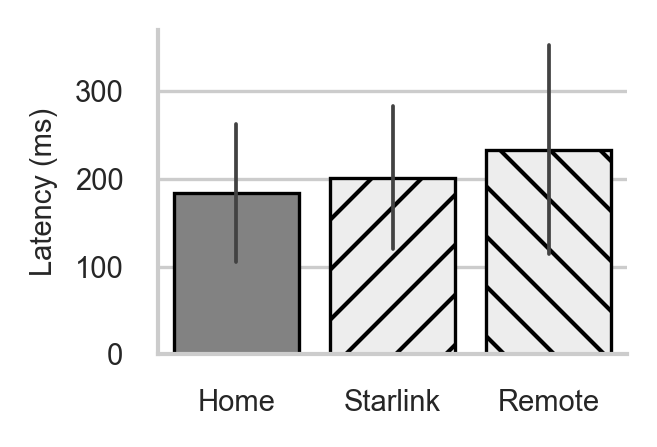

In [69]:
#temp = df_regs.loc['2022-06-03':]

#df_averaged = df.groupby([N_TYPE, N_REGIONS]).std().reset_index()

#styler = df_averaged.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_avg_bandwidth.tex'))
old = [N_HOME, N_STARLINK, N_STARLINK_REMOTE]
new = [N_HOME, 'Dish A', 'Dish F']
df_temp = df_combined
df_temp['label_type'] = df_temp[N_TYPE].map(dict(zip(old, new)))
sns.set_palette('Greys')
h = 1.5
aspect = WIDTH_THIRD / h
g_remote_avg = sns.catplot(data=df_temp,
                           sharey=False,
                           x='label_type', y=N_LATENCY,
                           order=new,
                           legend_out=False,
                           kind='bar', ci='sd',
                           palette=['C9', 'C0', 'C0'],
                           height=h, aspect=aspect)

num_locs = 1
hatches = itertools.cycle(['', '//', '\\\\'])
axes = g_remote_avg.axes.flatten()
for ax in axes:
    #ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    #ax.set(xticks=[])
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
        
#g_avg.figure.autofmt_xdate()
g_remote_avg.set(xlabel='')
g_remote_avg.set_titles(row_template="{row_name}")
g_remote_avg.tight_layout()

#df_averaged

In [31]:
#df_outliers[N_TYPE] = N_STARLINK_REMOTE
#df_outliers[N_TYPE] = df_outliers[N_TYPE].map({'Starlink Koeye': N_STARLINK_REMOTE})

In [70]:
g_remote_avg.savefig(f'{OUT_PATH}/2022-06-21_remote_ping_avg.pdf', bbox_inches='tight')

In [28]:
nt_perc = df_combined.groupby([N_TYPE, N_REGIONS]).quantile(.90)
nf_perc = df_combined.groupby([N_TYPE, N_REGIONS]).quantile(.95)
nn_perc = df_combined.groupby([N_TYPE, N_REGIONS]).quantile(.99)

In [30]:
def diff_table(percentile):
    df_perc = percentile.reset_index().pivot(index=N_REGIONS, columns=N_TYPE, values=N_LATENCY)
    df_perc['diff'] = df_perc[N_STARLINK_REMOTE] - df_perc[N_STARLINK]
    return df_perc.reset_index().pivot_table(columns=N_REGIONS, values='diff')
    
df_perc = diff_table(nt_perc)
df_perc = pd.concat([df_perc, diff_table(nf_perc)])
df_perc = pd.concat([df_perc, diff_table(nn_perc)])
df_perc['Percentile'] = ['90%', '95%', '99%']
df_perc = df_perc.set_index('Percentile')
df_perc

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Percentile,,,,,,,,,
90%,-4.00,28.0,31.0,32.0,33.5,30.0,57.0,45.0,12.0
95%,50.00,83.0,83.0,85.0,84.1,80.0,113.0,98.0,65.0
99%,465.51,492.0,499.0,493.0,496.0,495.0,532.0,517.0,486.0


In [13]:
df_type_avg = df_old.groupby(
    [N_REGIONS, N_TYPE]
).mean()
#apply(lambda x: x[N_HOME] - x[N_STARLINK])
df_type_avg

Latency (ms)  Outliers
Regions       Type                            
Bahrain       Home        258.341745  0.003269
              Starlink    266.696232  0.004873
Cape Town     Home        296.039889  0.005587
              Starlink    310.377467  0.006808
London        Home        152.046133  0.006495
              Starlink    168.085194  0.006616
Mumbai        Home        271.701787  0.001215
              Starlink    284.594823  0.005380
N. California Home         34.491404  0.008420
              Starlink     55.383745  0.006195
Sao Paulo     Home        191.006578  0.009956
              Starlink    213.843563  0.005903
Singapore     Home        196.848192  0.010495
              Starlink    198.684958  0.005600
Sydney        Home        152.464079  0.012172
              Starlink    230.887662  0.004760
Tokyo         Home        142.680309  0.010560
              Starlink    151.918970  0.004970

In [17]:
df_type_avg.groupby([N_REGIONS])[N_LATENCY].diff()

Regions        Type    
Bahrain        Home              NaN
               Starlink     8.354487
Cape Town      Home              NaN
               Starlink    14.337578
London         Home              NaN
               Starlink    16.039061
Mumbai         Home              NaN
               Starlink    12.893036
N. California  Home              NaN
               Starlink    20.892341
Sao Paulo      Home              NaN
               Starlink    22.836985
Singapore      Home              NaN
               Starlink     1.836766
Sydney         Home              NaN
               Starlink    78.423583
Tokyo          Home              NaN
               Starlink     9.238661
Name: Latency (ms), dtype: float64

In [110]:
df_star = df_outliers[df_outliers[N_TYPE] == N_STARLINK]
df_corr = df_star.pivot_table(index=N_TIMESTAMP, columns=N_REGIONS, values=N_LATENCY)
df_corr

In [112]:
df_corr = df_corr.corr()
df_corr

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Regions,,,,,,,,,
Bahrain,1.000000,0.531023,0.435916,0.523741,0.368044,0.512611,0.474942,0.352300,0.510409
Cape Town,0.531023,1.000000,0.530960,0.615328,0.538009,0.629372,0.617139,0.696385,0.526976
London,0.435916,0.530960,1.000000,0.533721,0.513696,0.515329,0.561255,0.494996,0.577317
Mumbai,0.523741,0.615328,0.533721,1.000000,0.493145,0.567466,0.569023,0.640166,0.498123
N. California,0.368044,0.538009,0.513696,0.493145,1.000000,0.483147,0.457279,0.390160,0.540791
Sao Paulo,0.512611,0.629372,0.515329,0.567466,0.483147,1.000000,0.492273,0.500691,0.555297
Singapore,0.474942,0.617139,0.561255,0.569023,0.457279,0.492273,1.000000,0.600782,0.609283
Sydney,0.352300,0.696385,0.494996,0.640166,0.390160,0.500691,0.600782,1.000000,0.538216
Tokyo,0.510409,0.526976,0.577317,0.498123,0.540791,0.555297,0.609283,0.538216,1.000000


In [82]:
file_path = os.path.join('output/Ping/', 'Percentiles.tex')
styler = df_perc.style
styler.format(precision=1)
styler.to_latex(file_path)